# Problem komiwojażera
Problem sformułowany już w XIX wieku. Za pierwszego autora, który go sformalizował uznaje się Karla Mengera. Jest to problem NP-trudny. 

Komiwojażer ma odwiedzić dokładnie raz każdą z wybranych miejscowości i powrócić do tej, w której swoją podróż zaczął. Znane są przy tym koszty przejazdy między każdą parą miejscowości. Drogę należy zaplanować tak, aby każda miejscowość odwiedzona została dokładnie raz i całkowity koszt podróży był najmniejszy.

Zakładać będziemy, że nasz graf jest grafem pełnym, bo to zapewnie nam w ogóle istnienie cyklu długości n. 

Rozważać można dwa typy problemu komiwojażera: symetryczny i niesymertryczny, tj. z grafem skierowanym i nieskierowanym. My rozważymy problem niesymetryczny, gdyż jest bardziej ogólny.

Zaimportujmy najpierw klasę grafów z zajęć.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
import math


In [2]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle

    def draw(self):
      """
      Draws the graph using networkx.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()

    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree

    def connected_components(self):
      """
      Szuka spójnych skłądowych w (nieskierowanym) grafie.
      Zwraca listę zbiorów wierzchołków.
      Uwaga: zerowy element listy zawiera wszystkie wierzchołki grafu
      """
      def DFS(u):
        """
        Przechodzenie w głąb - metoda wewnętrzna
        """
        for w in self.graph[u]:
          if w not in VT[0]:    # w jeszcze nieodwiedzony
            VT[0].add(w)        # już odwiedzony
            VT[-1].add(w)       # w ostatniej (aktualnej) spójnej składowej
            DFS(w)
      """
      VT - lista zbiorów wierzchołków (drzew DFS).
      VT[0] - docelowo lista wszystkich wierzchołków w grafie.
      """
      VT = [set([])]
      for v in self.graph:
        if not v in VT[0]:  # v - nieodwiedzony
          VT[0].add(v)      # już odwiedzony
          VT.append(set([v])) # zalążek nowej spójnej składowej
          DFS(v)
      return VT

    def connected_components_graphs(self):
      """
      Zwraca listę spójnych składowych (jako grafów).
      """
      components = self.connected_components()  # lista zbiorów wierzchołków
      component_graphs = []                     # zalążek listy grafów
      for component in components[1:]:
        subgraph = Graph()
        for vertex in component:
          subgraph.graph[vertex] = self.graph[vertex].copy()
        component_graphs.append(subgraph)
      return component_graphs

    def distance(self, v):
      """
      Oblicza odległości z wierzhołka v do każdego osiąglanego wierzchołka w grafie.
      Używa BFS. Wynik podany jako słownik (indeksowany etykietami wierzchołków).
      """
      dist = {v: 0}   # zalążek słownika
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if not w in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist
    
from queue import PriorityQueue

class WeigthtedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # dict initializer
    @classmethod
    def from_dict(cls, graph, weights):
        return cls(graph, weights)

    # przedefiniowanie wypisywania grafów
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}({self.weights[(v, u)]})"
            res += "\n"
        return res

    def add_arc(self, arc, weight = 1):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        super().add_arc(arc)
        self.weights[arc] = weight

    def add_edge(self, edge, weight = 1):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        super().add_edge(edge)
        self.weights[edge] = weight
        self.weights[(v, u)] = weight

    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Wczytujemy graf z pliku
        """
        graph = WeigthtedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # two words, the edge description
            if directed:
              graph.add_arc((words[0], words[1]))
            else:
              graph.add_edge((words[0], words[1]))
          elif len(words) >= 3:             # at least three words, first three are the weighted edge description
            if directed:
              graph.add_arc((words[0], words[1]), int(words[2]))
            else:
              graph.add_edge((words[0], words[1]), int(words[2]))
        file.close()
        return graph
    
    
    
    def draw(self):
      """
      Rysowanie grafu ważonego.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v, weight=self.weights[(u, v)])
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      labels = nx.get_edge_attributes(G, 'weight')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
      plt.show()


    def min_spanning_tree(self):
      """
      Oblicza drzewo rozpinające wg algorytmu Jarnika-Prima.
      """
      for v in self.graph:
        break
      wtree = WeigthtedGraph({v:[]}, {})
      total = 0   # całkowita waga
      q = PriorityQueue()
      for u in self.graph[v]:
        q.put((self.weights[(v, u)], v, u))
      while not q.empty():
        w, v, u = q.get()
        if not u in wtree.graph:
          wtree.add_edge((v, u), w)
          total += w
          for x in self.graph[u]:
            if not x in wtree.graph:
              q.put((self.weights[(u, x)], u, x))
      if len(wtree.graph) != len(self.graph):
        print("Graf jest niespójny. Zwrócopne drzewo dla jednej spójnej składowej.")
      return wtree, total


    def Dijkstra(self, s):
      """
      Algorytm Dijkstry. Wyznacza najkrótsze ścieżki z wierzchołka s
      """
      # Init
      dist = {}
      pred = {}
      for v in self.graph:
        dist[v] = float("inf")
        pred[v] = None
      dist[s] = 0
      q = PriorityQueue()
      q.put((dist[s], s))
      while not q.empty():
        d, u = q.get()
        if dist[u] >= d:
          for v in self.graph[u]:
            if dist[v] > dist[u] + self.weights[(u, v)]:
              dist[v] = dist[u] + self.weights[(u, v)]
              pred[v] = u
              q.put((dist[v], v))
      return dist, pred


    def network_flow(self):
      """
      Zwraca sieć przepływową zrobioną ze zwykłego grafu skierowanego, ważonego.
      Dodaje łuki wsteczne z przepustowością 0.
      """
      network = WeigthtedGraph()
      for u in self.graph:
        for v in self.graph[u]:
          network.add_edge((u, v), 0)
      for u in self.graph:
        for v in self.graph[u]:
          network.weights[(u,v)] = self.weights[(u,v)]
      return network


    def maxflow_EK(self, s, t):
      """
      Algorytm Edmondsa-Karpa znajduje maksymalny przepływ z wierzchołka s do t.
      """
      network = self.network_flow()
      n = len(network.graph)
      flow = {xx: 0 for xx in network.weights}
      # wyliczamy ścieżki powiększające przez BFS
      while True:
        pred = {s: None}  # słownik poprzedników
        cap = {s: float("inf")}  # słownik do przepustowości ścieżki
        queue = [s]
        while len(queue) > 0:
          u = queue.pop(0)
          for v in network.graph[u]:
            if (not v in pred) and network.weights[(u, v)] - flow[(u, v)] > 0:
              pred[v] = u
              cap[v] = min(cap[u], network.weights[(u, v)] - flow[(u, v)])
              if v == t:
                break
              else:
                queue.append(v)
          if v == t:
            break
        if not t in pred:     # koniec - nie ma s->t ścieżki
          break
        else:
          # przetwarzamy ścieżkę powiększającą
          v = t
          while v != s:
            u = pred[v]
            flow[(u, v)] += cap[t]
            flow[(v, u)] -= cap[t]
            v = u
      return flow
    
    @staticmethod
    def matrix(self):
      n = len(self.graph)
      M = np.full((n,n), float(0))
      
      for x in self.weights:
        M[int(x[0])-1][int(x[1])-1] = self.weights[x]
      
      return M



Najprostszym sposobem na znalezienie rozwiązania problemu komiwojażera jest przejrzenie wszystkich możliwych cykli i sprawdzenie, który ma najmniejszą wagę. To rozwiązanie jest jednak wysoce nieoptymalne, ponieważ wszystkich cykli jest $(n-1)!$, zatem już dla $n = 20$ mielibyśmy $19! > 10^{17}$ takich cykli, więc ich sprawdzenie zajęłoby lata. Stąd potrzebne są inne metody, jak algorytm podziału i ograniczeń.

Algorytm ten działa poprzez podział zbioru wszystkich cykli na te zawierające pewien łuk $(i, j)$ i te niezawierające go, a następnie sprawdzanie dolnych ograniczeń wag rozwiązań w obu podzbiorach. Następnie odrzucamy podzbiór z gorszym dolnym ograniczeniem. Algorytm wykonuje się aż do otrzymania cyklu Hamiltona. Algorytm opiera się na redukcji macierzy wag.

Zauważmy, że cykl Hamiltona wybiera z tej macierzy dokładnie jeden element z każdego wiersza i dokładnie jeden element z każdej kolumny. Zatem pomniejszenie wszystkich elementów któregoś wiersza lub którejś kolumny o pewną stałą, to waga każdego cyklu Hamiltona pomniejszy się o tę stałą. Zatem względny koszt tych cykli pozostaje bez zmian, a rozwiązanie optymalne optymalnym. 
Zatem jeśli po odjęciu stałych od wierszy i kolumn każdy wiersz io kolumna zawierają dokładnie jedno zero, a reszta wartości jest nieujemna, to suma liczb odciętych jest dolnym ograniczeniem długości dowolnego rozwiązania. 


Rozważmy przykładowo graf:

1: 2(3) 3(93) 4(13) 5(33) 6(9)
2: 1(4) 3(77) 4(42) 5(21) 6(16)
3: 2(17) 1(45) 4(36) 5(16) 6(28)
4: 2(90) 3(80) 1(39) 5(56) 6(7)
5: 2(46) 3(88) 4(33) 1(28) 6(25)
6: 2(88) 3(18) 4(46) 5(92) 1(3)



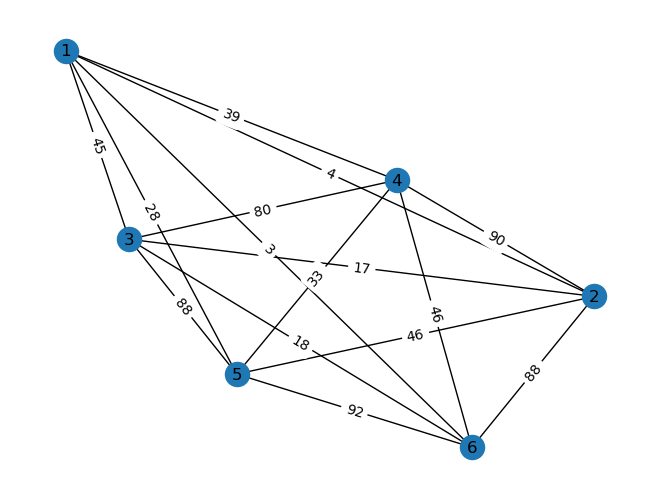

In [3]:
G = WeigthtedGraph({"1": "2" "3" "4" "5" "6", "2": "1" "3" "4" "5" "6", "3": "2" "1" "4" "5" "6", "4": "2" "3" "1" "5" "6", "5": "2" "3" "4" "1" "6", "6": "2" "3" "4" "5" "1"}, {("1","2"): 3, ("1","3"):93, ("1","4"):13, ("1","5"):33,("1","6"): 9, ("2","1"):4, ("2","3"):77, ("2","4"):42, ("2","5"):21, ("2","6"):16, ("3","1"):45, ("3","2"):17, ("3","4"):36, ("3","5"):16, ("3","6"):28, ("4","1"):39, ("4","2"):90, ("4","3"):80, ("4","5"):56, ("4","6"):7, ("5","1"):28, ("5","2"):46, ("5","3"):88, ("5","4"):33, ("5","6"):25, ("6","1"):3, ("6","2"):88, ("6","3"):18, ("6","4"):46, ("6","5"):92})
print(G)
WeigthtedGraph.draw(G)



Ma on macierz odległości o następującej postaci:

$\begin{bmatrix}
\infty & 3 & 93 & 13 & 33 & 9\\
4 & \infty & 77 & 42 & 21 & 16\\
45 & 17 & \infty & 36 & 16 & 28\\
39 & 90 & 80 & \infty & 56 & 7\\
28 & 46 & 88 & 33 & \infty & 25\\
3 & 88 & 18 & 46 & 92 & \infty
\end{bmatrix}$

Jej pierwsza redukcja to odjęcie 3, 4, 16, 7, 25 i 3 od wierszy oraz 15 i 8 od kolumny 3 i 4. Po tych operacjach dolne ogrnoczenie wynosi 81, a macierz wygląda następująco:

$\begin{bmatrix}
\infty & 0 & 75 & 2 & 30 & 6\\
0 & \infty & 58 & 30 & 17 & 12\\
29 & 1 & \infty & 12 & 0 & 12\\
32 & 83 & 58 & \infty & 49 & 0\\
3 & 21 & 48 & 0 & \infty & 0\\
0 & 85 & 0 & 35 & 89 & \infty
\end{bmatrix}$

Teraz wybieramy łuk, którego wybór spowoduje wzrost dolnego ograniczenia o największą wartość. W tym wypadku jest to łuk (6,3). Wówczas możemy podstawić w miejscu (6,3) wartość $\infty$, co pozwala odjąć 48 od trzeciej kolumny (zatem nasze ograniczenie bez (6,3) to 81+48 = 129), gdyż macierz wygląda tak:

$\begin{bmatrix}
\infty & 0 & 75 & 2 & 30 & 6\\
0 & \infty & 58 & 30 & 17 & 12\\
29 & 1 & \infty & 12 & 0 & 12\\
32 & 83 & 58 & \infty & 49 & 0\\
3 & 21 & 48 & 0 & \infty & 0\\
0 & 85 & \infty & 35 & 89 & \infty
\end{bmatrix}$

Teraz można usunąć wiersz szósty i kolumnę trzecią i nasza macierz wygląda następująco:

$\begin{bmatrix}
\infty & 0  & 2 & 30 & 6\\
0 & \infty  & 30 & 17 & 12\\
29 & 1  & 12 & 0 & \infty\\
32 & 83  & \infty & 49 & 0\\
3 & 21 & 0 & \infty & 0\\
\end{bmatrix}$

Jest to macierz opsiująca zbiór rozwiązań wykorzystujących łuk (6,3), ich dolne ograniczenia to wciąż 81. Teraz wybieramy łuk (4,6). Wówczas macierz rozwiązań z (6, 3), ale bez (4,6) ma ograniczenie 81+32=113, bo wygląda tak:

$\begin{bmatrix}
\infty & 0  & 2 & 30 & 6\\
0 & \infty  & 30 & 17 & 12\\
29 & 1  & 12 & 0 & \infty\\
32 & 83  & \infty & 49 & \infty\\
3 & 21 & 0 & \infty & 0\\
\end{bmatrix}$

Z kolei, wybirając ten łuk, redukujemy macierz do:

$\begin{bmatrix}
\infty & 0  & 2 & 30 \\
0 & \infty  & 30 & 17 \\
29 & 1  & \infty & 0 \\
3 & 21 & 0 & \infty \\
\end{bmatrix}$

Ważne jest tu też to, że na pierwotnym miejscu łuku (3, 4) wpisujemy $\infty$, bo ten łuk jest nieużyteczny. Teraz wykonujemy podział łukiem (2,1). Dla rozwiązań bez tego łuku macierz wygląda tak:

$\begin{bmatrix}
\infty & 0  & 2 & 30 \\
\infty & \infty  & 30 & 17 \\
29 & 1  & 12 & 0 \\
3 & 21 & 0 & \infty \\
\end{bmatrix}$

Możemy zatem  odjąć 3 od pierwszej kolumny i 17 od drugiego wiersza. Stąd dla rozwiąza bez łuku (2,1) dolne ograniczenie wynosi 101. Przejdźmy jednak do rozwiązań z tym łukiem. Po usunięciu drugiego wiersza i pierwszej kolumny nasza macierz wygląda następująco:

$\begin{bmatrix}
\infty  & 2 & 30 \\
1  & \infty & 0 \\
21 & 0 & \infty \\
\end{bmatrix}$

Zaznczmy tu, że pojawiła się dodatkowa nieskończoność dla łuku (1,2), a w pierwszej kolumnie i wierszu nie ma 0, więc nasze dolne ograniczenie musi wzrosnąć na tym etapie o 3, a macierz zmienić się na:

$\begin{bmatrix}
\infty  & 0 & 28 \\
0  & \infty & 0 \\
20 & 0 & \infty \\
\end{bmatrix}$

Ostatni łuk jaki mamy wolność wybrać tp (1,4). Dla rozwiązań bez tego łuku macierz wygląda tak:

$\begin{bmatrix}
\infty  & \infty & 28 \\
0  & \infty & 0 \\
20 & 0 & \infty \\
\end{bmatrix}$,

więc dla rozwiązań bez niego dolne ograniczenie to $84+28=112$.

Dla rozwiązań z tym łukiem kończymy, mając macierz: 
$\begin{bmatrix}
0  &  0 \\
20 & \infty \\
\end{bmatrix}$

i kończymy drogę łukiem (5, 2), bo już nie mamy wyboru. Ostateczna ścieżka to [1,4,6,3,5,2,1].

Poniższa implementacja w Pythonie również działa na zasadzie podziału, jednak wykorzystuje heurystykę.

In [ ]:
# Kopiowanie rozwiązania częściowego do ostatecznego
def copyToFinal(curr):
    final[:N + 1] = curr[:]
    final[N] = curr[0]

# Znajdowanie najniższego kosztu dla krawędzi o końcu i
def firstMin(M, i):
    min = float("inf")
    for k in range(N):
        if M[i][k] < min and i != k:
            min = M[i][k]

    return min

# Znajdowanie drugiej najtańszej krawędzi o końcu i
def secondMin(M, i):
    first, second = float("inf"), float("inf")
    for j in range(N):
        if i == j:
            continue
        if M[i][j] <= first:
            second = first
            first = M[i][j]

        elif(M[i][j] <= second and 
             M[i][j] != first):
            second = M[i][j]

    return second

# funkcja pomocnicza biorąca:
# curr_bound -> dolne ograniczenie dla korzenia
# curr_weight-> waga dotychczasowej drogi
# level-> aktualny poziom przemieszczenia w drzewie przeszukiwań
# curr[] -> dotychczasowa ścieżka
def TSPRec(M, curr_bound, curr_weight, 
              level, curr, visited):
    global final_res
    if level == N:
        # sprawdzanie, czy istnieje łuk z ostatniego wierzchołka ściezki do pierwszego
        if M[curr[level - 1]][curr[0]] != 0:
            curr_res = curr_weight + M[curr[level - 1]]\
                                        [curr[0]]
            if curr_res < final_res:
                copyToFinal(curr)
                final_res = curr_res
        return
    #dla poziomu innego niż N iterujemy dla każdego wierzchołka, budując drzewo przeszukiwań
    for i in range(N):
        if (M[curr[level-1]][i] != 0 and
                            visited[i] == False):
            temp = curr_bound
            curr_weight += M[curr[level - 1]][i]

            # obliczenie jest inne dla poziomu 2
            if level == 1:
                curr_bound -= ((firstMin(M, curr[level - 1]) + 
                                firstMin(M, i)) / 2)
            else:
                curr_bound -= ((secondMin(M, curr[level - 1]) +
                                 firstMin(M, i)) / 2)

            # Jeśli dolne ograniczenie jest mniejsze niż finalne, musimy iść głębiej
            if curr_bound + curr_weight < final_res:
                curr[level] = i
                visited[i] = True
                
                # rekursja
                TSPRec(M, curr_bound, curr_weight, 
                       level + 1, curr, visited)
            # w przeciwynym wypadku odcinamy odgałęzienie

            curr_weight -= M[curr[level - 1]][i]
            curr_bound = temp
            visited = [False] * len(visited)
            for j in range(level):
                if curr[j] != -1:
                    visited[curr[j]] = True

# ostateczna droga
def TSP(adj):
    curr_bound = 0
    curr = [-1] * (N + 1)
    visited = [False] * N

    # początkowe ograniczenie
    for i in range(N):
        curr_bound += (firstMin(adj, i) + 
                       secondMin(adj, i))

    # zaokrąglamy
    curr_bound = math.ceil(curr_bound / 2)
    visited[0] = True
    curr[0] = 0
    TSPRec(adj, curr_bound, 0, 1, curr, visited)

M_G = WeigthtedGraph.matrix(G)
N = np.shape(M_G)[0]


final= [None] * (N + 1)


visited = [False] * N


final_res = float("inf")

TSP(M_G)

print("Minimalny koszt :", final_res)
print("Przebyta droga : ", end = ' ')
for i in range(N + 1):
    print(final[i], end = ' ')

Minimalny koszt : 104.0
Przebyta droga :  0 3 5 2 1 4 0 

Jak widać nasza implementacja znalazła drugie rozwiązanie, którym jest (po przeindeksowaniu) $1,4,6,3,2,5,1$, również o wadze łącznej wadze 104. 

Innym podejściem, choć nierzadko nieoptymalnym jest podejście zachłanne.

In [22]:
def greedy(M):
    X = deepcopy(M)
    N = np.shape(X)[0]
    path = [0]
    s = 0
    visited = [0]

    for i in range(N - 1):
        current = path[-1]
        X[current][current] = float("inf")
        m = float("inf")
        next_node = None
        for j in range(N):
            if X[current][j] < m and j not in visited:
                m = X[current][j]
                next_node = j
        if next_node is None:
            break  # brak możliwego następnego kroku
        path.append(next_node)
        visited.append(next_node)
        s += m

    # domknięcie cyklu
    s += M[path[-1]][0]
    path.append(0)
    return path, s
print(greedy(M_G))

([0, 1, 5, 2, 4, 3, 0], np.float64(125.0))


Wypada nie tak źle, jak można by się spodziewać. Algorytm zachłanny jest przykładem algorytmu przybliżającego. Jednym z najlepszych algorytmów przybliżających może być algorytm Christofidesa, który dawał drogę co najwyżej o 50 % większą niż optymalna. Ma on złożoność w najgorszym wypadku $\mathcal{O}(n^3)$.

Struktura tego algorytmu ma sie następująco:

1. Dla grafu $G$ tworzymy minimalne drzewo rozpinające.
2. Niech $O$ będzie zbiorem wierzchołków o nieparzystym stopniu w $T$. Znajdujemy minimalne skojarzenie doskonałe $M$ na wierzchołkach $O$ spośród krawędzi grafu $G$.
3. Tworzymy multigraf $H$ z $M$ i $T$
4. Wyznaczamy cyll Eulera w grafie $H$ ( ma on wsyzstkie wierzchołki parzystego stopnia)
5. Z cyklu Eulera tworzymy cykl Hamiltona poprzez pomijanie odwiedzanych wierzchołków


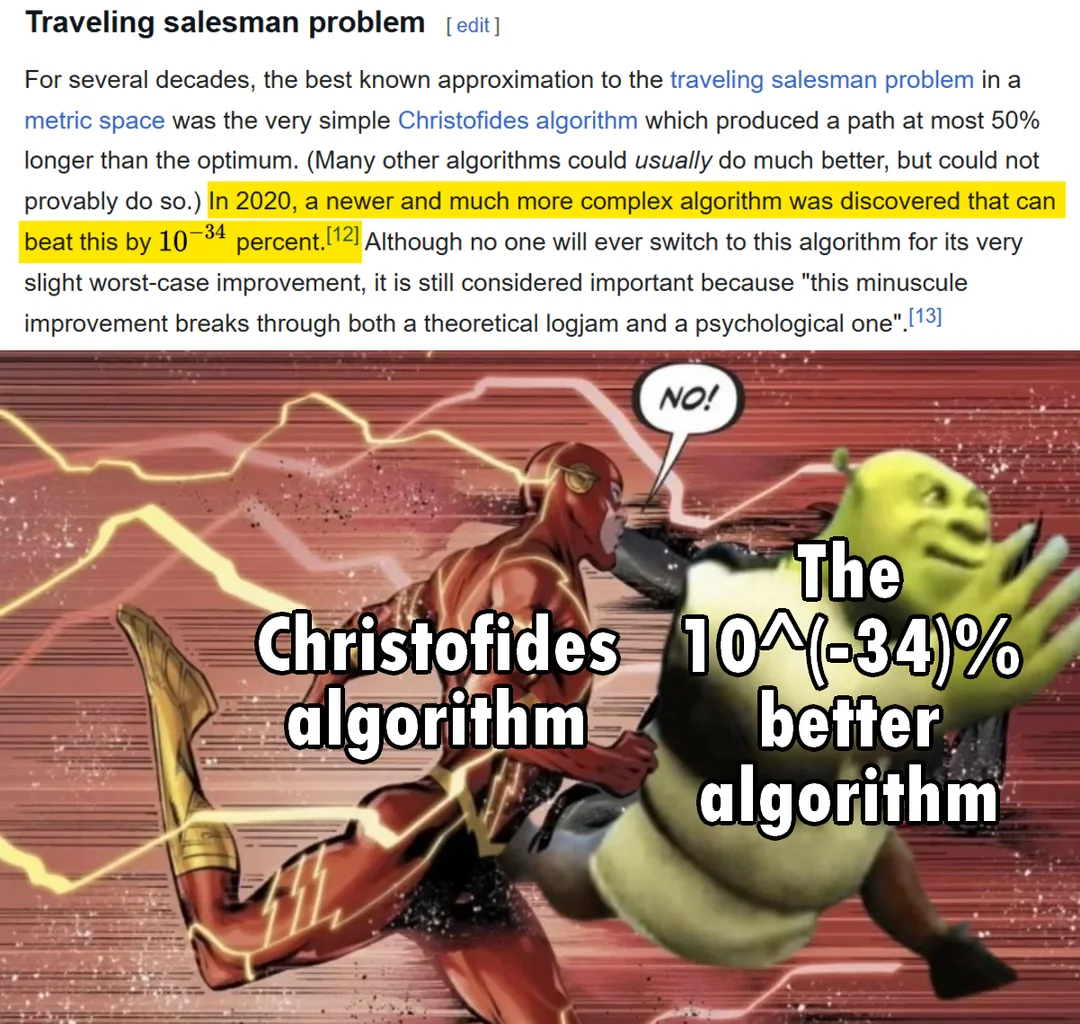

Bibliografia:

Maciej M. Sysło, Narsingh Deo, Janusz S. Kowalik, "Algorytmy Optymalizacji dyskretnej z programami w języku Pascal", Warszawa 1993

strona internetowa geeksforgeeks.com
